In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from cv2 import dct

In [49]:
def zigzag(input):

    h = 0
    v = 0

    vmin = 0
    hmin = 0

    vmax = input.shape[0]
    hmax = input.shape[1]
    i = 0

    output = np.zeros(( vmax * hmax))

    while ((v < vmax) and (h < hmax)):
        if ((h + v) % 2) == 0:
            
            if (v == vmin):
                output[i] = input[v, h]

                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        

                i = i + 1

            elif ((h == hmax -1 ) and (v < vmax)):
                output[i] = input[v, h] 
                v = v + 1
                i = i + 1

            elif ((v > vmin) and (h < hmax -1 )):
                output[i] = input[v, h] 
                v = v - 1
                h = h + 1
                i = i + 1

        
        else:

            if ((v == vmax -1) and (h <= hmax -1)):
                output[i] = input[v, h] 
                h = h + 1
                i = i + 1
        
            elif (h == hmin):
                output[i] = input[v, h] 

                if (v == vmax -1):
                    h = h + 1
                else:
                    v = v + 1

                i = i + 1

            elif ((v < vmax -1) and (h > hmin)):
                output[i] = input[v, h] 
                v = v + 1
                h = h - 1
                i = i + 1

        if ((v == vmax-1) and (h == hmax-1)):
            output[i] = input[v, h] 
            break
    return output

In [50]:
def get_features(data):
    datashape = data.shape
    datadct = np.zeros(datashape)
    datazigzag = np.zeros((data.size//64,64))
    features = np.zeros(data.size//64)
    k=0
    for i in np.r_[:datashape[0]:8]:
        for j in np.r_[:datashape[1]:8]:
            datadct[i:(i+8),j:(j+8)] = dct(data[i:(i+8),j:(j+8)]/255.0)
            datazigzag[k,:] = zigzag(datadct[i:(i+8),j:(j+8)])
            index = np.argsort(abs(datazigzag[k,:]))
            features[k] = index[-2]
            k+=1
    return features

In [51]:
def get_blocks_class(data):
    datashape = data.shape
    whiteblock = 0
    blockclass = list()
    for i in np.r_[:datashape[0]:8]:
        for j in np.r_[:datashape[1]:8]:
            black = 0
            white = 0
            for n in range(i,i+8):
                for m in range(j,j+8):
                    if data[n,m]==255.0:
                        white+=1
                    else:
                        black+=1
                if white>black:
                    whiteblock+=1
                    blockclass.append(1)
                else:
                    blockclass.append(0)
    return whiteblock,blockclass

In [52]:
#Reading the images in grayscale
mask = Image.open('F://Uni/991/Pattern/SPR_HW2/HW02_99131043/P5/leo1_mask.png').convert('L')
leo1mask = np.array(mask)
img = Image.open('F://Uni/991/Pattern/SPR_HW2/HW02_99131043/P5/leo1.png').convert('L')
leo1 = np.array(img)

In [53]:
#calculating prior knowledge
n_white_pix = np.sum(leo1mask == 255)
prior_messi = n_white_pix/leo1mask.size
prior_field = 1 - prior_messi
print("Prior of Messi: ", prior_messi, " Prior of Field: ", prior_field )

Prior of Messi:  0.35684313725490197  Prior of Field:  0.6431568627450981


In [54]:
leo1features = get_features(leo1)
messifeatures = list()
fieldfeatures = list()
for i in range(leo1features.size):
    if classes[i]==1:
        messifeatures.append(leo1features[i])
    else:
        fieldfeatures.append(leo1features[i])

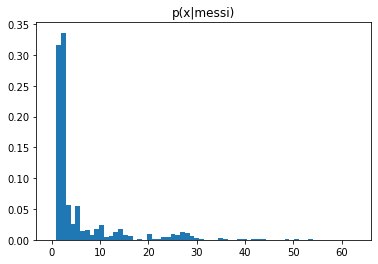

In [55]:
probmessi,binsmessi,_ = plt.hist(messifeatures, 64, range=(0,63),density='normalize')
plt.title('p(x|messi)')
plt.show()

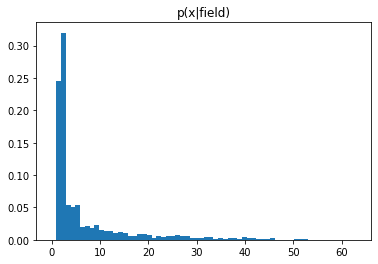

In [56]:
probfield,binsfield,_ = plt.hist(fieldfeatures, 64, range=(0,63),density='normalize')
plt.title('p(x|field)')
plt.show()

In [57]:
posteriormessi = probmessi*priormessi
posteriorfield = probfield*priorfield

In [58]:
print('Posterior Probability of Messi',sum(posteriormessi))
print('Posterior Probability of Field',sum(posteriorfield))

Posterior Probability of Messi 0.3601369436663557
Posterior Probability of Field 0.6557360722066604


In [59]:
#Reading the images in grayscale
mask = Image.open('F://Uni/991/Pattern/SPR_HW2/HW02_99131043/P5/leo2_mask.png').convert('L')
leo2mask = np.array(mask)
img = Image.open('F://Uni/991/Pattern/SPR_HW2/HW02_99131043/P5/leo2.png').convert('L')
leo2 = np.array(img)

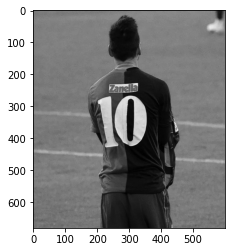

In [60]:
plt.imshow(leo2, cmap='gray')

In [61]:
leo2features = get_features(leo2)
print(leo2features)

[42. 29.  5. ...  2. 29. 21.]


In [62]:
posteriorblocks = posteriormessi>=posteriorfield

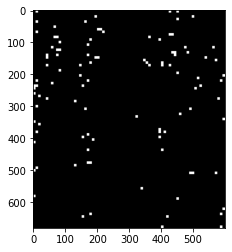

In [63]:
answer = np.zeros_like(leo2)

b=0
for i in range(0,answer.shape[0],8):
    for j in range(0,answer.shape[1],8):
        
        answer[i:i+8,j:j+8] = posteriorblocks[int(leo2features[b])]
        b+=1
plt.imshow(answer, cmap='gray')

In [64]:
e1 = np.sum(((leo2mask/255) == 1) & (answer == 0)) / np.sum((leo2mask/255) == 0)
e2 = np.sum(((leo2mask/255) == 0) & (answer == 1)) / np.sum((leo2mask/255) == 1)

prob_of_error = priormessi*e2 + priorfield*e1
print('Error:',prob_of_error)

Error: 0.30633931276397
